# Import Libraries

In [1]:
# uncomment to pip install libraries if libraries are not installed
#!pip install pandas prophet numpy scikit-learn seaborn fastf1

# import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.make_holidays import make_holidays_df
import fastf1
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\thach\anaconda3\envs\notebook-6.4.12\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# Data Preparation

In [2]:
# read file
df_original = pd.read_csv('../data/edarrivals.csv', low_memory=False)
df = df_original.copy()

# Remove all cancelled cases
df = df[df['A&E Discharge Type Description']!='Cancellation']

# counts cases per day
df['A&E Admit Date'] = df['A&E Admit Date'].str.strip()
df['A&E Admit Date'] = pd.to_datetime(df['A&E Admit Date'], format='mixed', dayfirst=True)
df_cases_per_day = df.value_counts('A&E Admit Date').reset_index()

# keep only 2022–2024
df_cases_per_day_2022_2024 = df_cases_per_day[
    df_cases_per_day['A&E Admit Date'].dt.year.isin([2022, 2023, 2024])
]

# sort by date
df_cases_per_day_2022_2024 = df_cases_per_day_2022_2024.copy() # Removes warning
df_cases_per_day_2022_2024.sort_values(by='A&E Admit Date', inplace=True)

# rename columns, prophet requires column names ds for date and y for target
df_cases_per_day_2022_2024 = df_cases_per_day_2022_2024.rename(columns={'A&E Admit Date':'ds',
                                                                        'count':'y'})


In [3]:
def generate_f1_df():
    years = [2022, 2023, 2024] #f1 cancelled in 2020 and 2021
    all_races = []
    for year in years:
        df_f1_year = fastf1.get_event_schedule(year)
        df_f1_year = df_f1_year[df_f1_year['Country']=="Singapore"]
        df_f1_year = df_f1_year[['EventDate', 'Session1Date']]
        all_races.append(df_f1_year)
    df_f1 = pd.concat(all_races)
    df_f1['Session1Date'] = pd.to_datetime(df_f1['Session1Date']).dt.tz_localize(None)
    df_f1['EventDate'] = pd.to_datetime(df_f1['EventDate']).dt.tz_localize(None)
    df_f1['Session1Date'] = pd.to_datetime(df_f1['Session1Date']).dt.normalize()
    df_f1['EventDate'] = pd.to_datetime(df_f1['EventDate']).dt.normalize()
    def get_f1_dates(row):
        return pd.date_range(start=row['Session1Date'], end=row['EventDate'])
    df_f1 = df_f1.apply(get_f1_dates, axis=1)
    df_f1 = pd.DataFrame(df_f1.explode(), columns=['ds'])
    df_f1['f1_event'] = 1
    return df_f1

df_f1 = generate_f1_df()

# add f1 event feature, with 4 days before and 2 days after event incorporated as lag
df_cases_per_day_2022_2024 = pd.merge(df_cases_per_day_2022_2024, df_f1, how='left', on='ds')
df_cases_per_day_2022_2024['f1_event'] = df_cases_per_day_2022_2024['f1_event'].fillna(0).astype(int)
temp_events = df_cases_per_day_2022_2024['f1_event'].replace(0, np.nan)
df_cases_per_day_2022_2024['f1_event'] = (
    temp_events
    .bfill(limit=4)
    .ffill(limit=2)
    .fillna(0)
    .astype(int)
)

req         WARNING 	DEFAULT CACHE ENABLED! (104.0 KB) C:\Users\thach\AppData\Local\Temp\fastf1


In [4]:

def moe_school_holidays():
    # list manually obtained from MOE website
    moe_holidays_list = [
        #['13-03-2021', '20-01-2021'], ['29-05-2021', '27-06-2021'], ['04-09-2021', '12-09-2021'], ['20-11-2021', '31-12-2021'],
        ['12-03-2022', '20-03-2022'], ['28-05-2022', '26-06-2022'], ['03-09-2022', '11-09-2022'], ['19-11-2022', '31-12-2022'], 
        ['11-03-2023', '19-03-2023'], ['27-05-2023', '25-06-2023'], ['02-09-2023', '10-09-2023'], ['18-11-2023', '31-12-2023'],
        ['09-03-2024', '17-03-2024'], ['25-05-2024', '23-06-2024'], ['31-08-2024', '08-09-2024'], ['16-11-2024', '31-12-2024']
    ]
    temp_list = []
    for date in moe_holidays_list:
        date_range = pd.date_range(start=pd.to_datetime(date[0], dayfirst=True), 
                                       end=pd.to_datetime(date[1], dayfirst=True))
        temp_list.append(pd.Series(date_range))
    df_moe_school_holidays = pd.DataFrame(pd.concat(temp_list), columns=['ds'])
    df_moe_school_holidays['school_holiday'] = 1
    return df_moe_school_holidays

df_moe_school_holidays = moe_school_holidays()

# add moe school holidays feature (does not include poly)
df_cases_per_day_2022_2024 = pd.merge(df_cases_per_day_2022_2024, df_moe_school_holidays, how='left', on='ds')
df_cases_per_day_2022_2024['school_holiday'] = df_cases_per_day_2022_2024['school_holiday'].fillna(0).astype(int)


# Modelling

In [5]:
year_list = [2022, 2023, 2024]
sg_holidays = make_holidays_df(year_list=year_list, country='SG')
sg_holidays['lower_window'] = -2
sg_holidays['upper_window'] = 1
m = Prophet(holidays=sg_holidays, seasonality_mode='multiplicative')
m.add_regressor('f1_event')
#m.add_regressor('school_holiday')
m.fit(df_cases_per_day_2022_2024)

09:43:01 - cmdstanpy - INFO - Chain [1] start processing
09:43:01 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
# test model using cross-validation
df_cv = cross_validation(m, initial='729 days', period='1 days', horizon='3 days', parallel="processes")

# Evaluation and Conclusion

In [7]:
# evaluate test cross-validation results
df_performance = performance_metrics(df_cv)
df_performance

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,565.204609,23.774032,18.596750,0.050590,0.042252,0.050093,0.744505
1,2 days,555.362904,23.566139,18.545699,0.050396,0.041380,0.049962,0.744505
2,3 days,541.538528,23.270980,18.436156,0.050216,0.041073,0.049725,0.755495


# Other

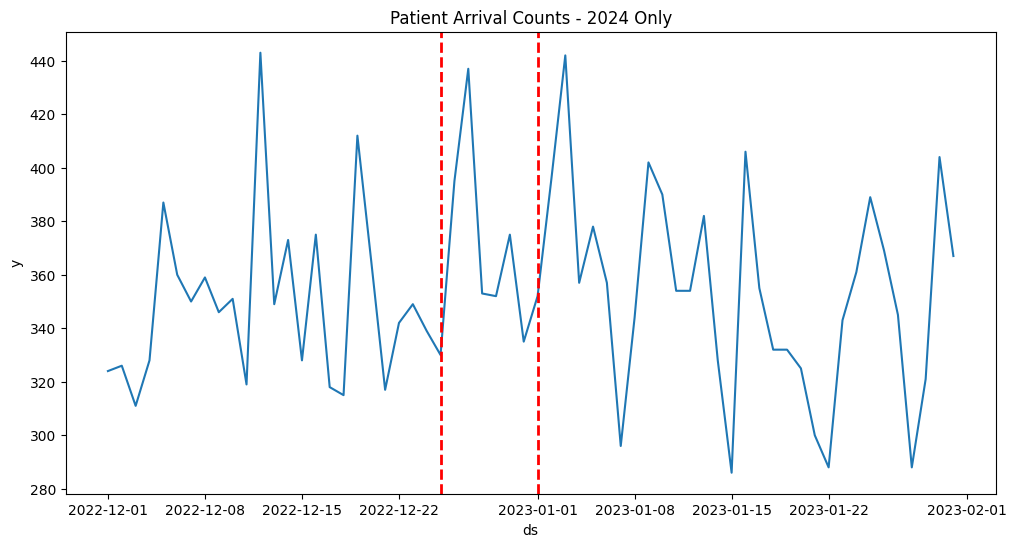

In [12]:
# Select dates between Dec 1, 2022 and Jan 31, 2023
df_2024 = df_cases_per_day_2022_2024[
    (df_cases_per_day_2022_2024['ds'] >= '2022-12-01') & 
    (df_cases_per_day_2022_2024['ds'] <= '2023-01-31')
]

# 2. PLOT: Use lineplot instead of scatterplot
plt.figure(figsize=(12, 6)) # Optional: Makes the chart wider and easier to read
sns.lineplot(data=df_2024, x='ds', y='y')

target_dates = ['2022-12-25', '2023-01-01']
for date_str in target_dates:
    # Convert string to datetime for correct placement
    dt_object = pd.to_datetime(date_str)
    
    # Draw the line
    plt.axvline(x=dt_object, color='red', linestyle='--', linewidth=2)

plt.title("Patient Arrival Counts - 2024 Only")
plt.show()

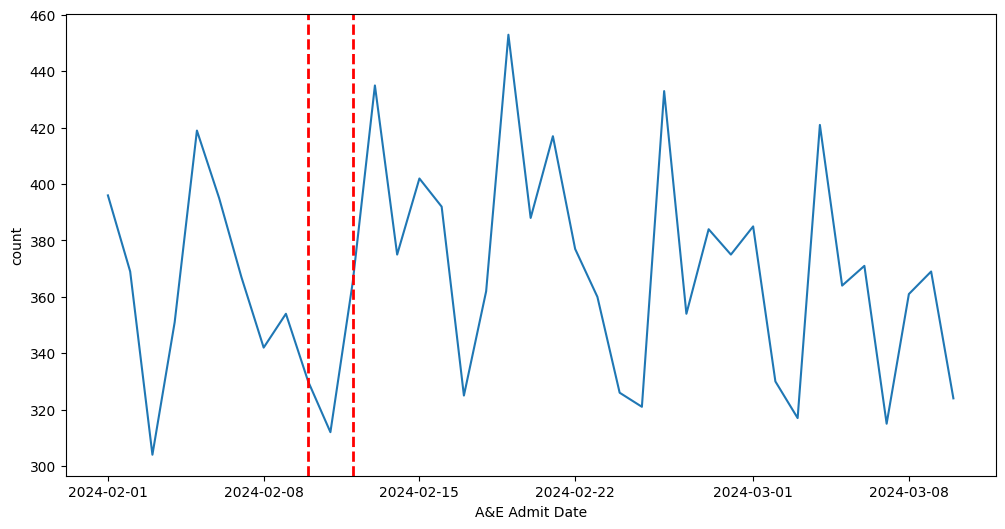

In [13]:
# Select dates between Dec 1, 2022 and Jan 31, 2023
start_year = 2024
end_year = start_year

df_2024 = df_cases_per_day[
    (df_cases_per_day['A&E Admit Date'] >= f'{start_year}-02-01') & 
    (df_cases_per_day['A&E Admit Date'] <= f'{end_year}-03-10')
]

# 2. PLOT: Use lineplot instead of scatterplot
plt.figure(figsize=(12, 6)) # Optional: Makes the chart wider and easier to read
sns.lineplot(data=df_2024, x='A&E Admit Date', y='count')

target_dates = [f'{start_year}-02-10', f'{end_year}-02-12']
for date_str in target_dates:
    # Convert string to datetime for correct placement
    dt_object = pd.to_datetime(date_str)
    
    # Draw the line
    plt.axvline(x=dt_object, color='red', linestyle='--', linewidth=2)

plt.show()

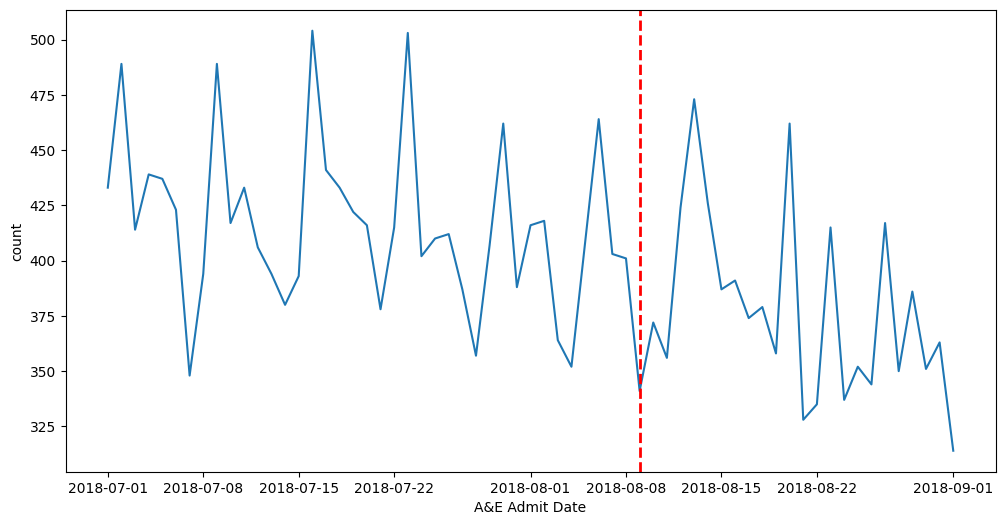

In [14]:
# Select dates between Dec 1, 2022 and Jan 31, 2023
start_year = 2018
end_year = start_year

df_2024 = df_cases_per_day[
    (df_cases_per_day['A&E Admit Date'] >= f'{start_year}-07-01') & 
    (df_cases_per_day['A&E Admit Date'] <= f'{end_year}-09-01')
]

# 2. PLOT: Use lineplot instead of scatterplot
plt.figure(figsize=(12, 6)) # Optional: Makes the chart wider and easier to read
sns.lineplot(data=df_2024, x='A&E Admit Date', y='count')

target_dates = [f'{start_year}-08-09']
for date_str in target_dates:
    # Convert string to datetime for correct placement
    dt_object = pd.to_datetime(date_str)
    
    # Draw the line
    plt.axvline(x=dt_object, color='red', linestyle='--', linewidth=2)

plt.show()